In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
from datetime import datetime
import warnings
from IPython.display import HTML, display
import seaborn as sns
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Strategy Code

In [94]:
class generateData:
    
    def __init__(self):
        ''' Init function for generateData class, this class is responsible for generating the dataset 
        to be by the other classes '''
        self.portfolio_path : str = 'Industry_Portfolios_49_2023.csv'
        self.FF_path : str = 'FF_data_2023_monthly.csv'
        self.CombinedData = self.getCombinedData()
    
    def getPortfolioData(self) -> pd.DataFrame:
        '''This function imports the 49 industry portfolio data, replaces any -99.99 
        values with Nan and returns a dataframe'''
        dateparser = lambda x: datetime.strptime(x, '%Y%m')
        df : pd.DataFrame = pd.read_csv(self.portfolio_path, parse_dates=['Date'],  date_parser=dateparser)
        df['Date'] = pd.DatetimeIndex(df['Date']) 
        df.set_index('Date',inplace=True)
        df.replace(-99.99,np.nan,inplace = True)
        df = df.divide(100)
        
        return df
    
    def getFFData(self) -> pd.DataFrame:
        '''This function imports the Fama-French data, replaces any -99.99 values 
        with Nan and returns a dataframe'''
        dateparser = lambda x: datetime.strptime(x, '%Y%m')
        df_ff : pd.DataFrame = pd.read_csv(self.FF_path, parse_dates=['Date'],  date_parser=dateparser)
        df_ff['Date'] = pd.DatetimeIndex(df_ff['Date']) 
        df_ff.set_index('Date',inplace=True)
        df_ff = df_ff.divide(100)
        df_ff['total_ret'] = df_ff['Mkt-RF']+df_ff['RF']
        
        return df_ff
    
    def getCombinedData(self) -> pd.DataFrame:
        '''This function generates the combined dataset'''
        ff_data : pd.DataFrame = self.getFFData()
        pf_data : pd.DataFrame = self.getPortfolioData()
        combined : pd.DataFrame = pd.merge(pf_data,ff_data,how = 'inner',
                                           left_index = True,right_index = True)
        combined.index = combined.index + pd.offsets.MonthEnd(1) #adjusting dates to month end
        combined = combined[combined.index>'1950-01-01'] #from 1950 on
        
        return combined

In [95]:
class generateBetas(generateData):
    
    def __init__(self):
        '''Init function for the generateBetas class, loads all objects from the parent class too
        The purpose of this class is to calcuate the betas over a rolling window
        '''
        super().__init__()
       
        
    def getBetas(self,df_comb) -> pd.DataFrame:
        '''calcuates betas given a window of returns for each industry'''
        #calculate the variance-covariance matrix of the returns
        cov_mtx : pd.DataFrame = df_comb.cov() 
        #removing any unneeded column and leaving just the 49 industries and the total returns
        sector_mkt_cov : pd.DataFrame = cov_mtx.loc[df_comb.columns[:-5],'total_ret']
        #selecting the variance of the total returns
        mkt_var : float = cov_mtx.loc['total_ret','total_ret']
        #calculating the betas
        betas : pd.Series = sector_mkt_cov/mkt_var
        #converting to df
        betas_df : pd.DataFrame = pd.DataFrame({'Beta':betas})
        
        return betas_df
    
    def calcBetasRolling(self,window) -> pd.DataFrame:
        '''calculates a df of betas over a rolling window of inputted length'''
        #loading the combined data from the parent class
        data = super().getCombinedData().reset_index()
        #calculating the rolling betas and storing them in a dictionary
        rolling_betas = {}
        for index,row in data.iterrows():
            if index>=int(window):
                window_data = data[(index-int(window)):index]
                window_data.set_index('Date',inplace = True)
                window_betas = self.getBetas(window_data)
                rolling_betas[data.loc[index,'Date']] = window_betas
                
        #generating the final df and setting the index
        df = pd.concat(rolling_betas.values(),axis = 1).T.reset_index(drop = True)
        df.index= rolling_betas.keys() 
        
        return df

In [96]:
class betAgainstBeta(generateBetas):
    
    def __init__(self,weighting_method = 1,divisions = 0,window = 12,max_leverage = 10):
        '''Init function for the betAgainstBeta class, also calls all 
        objects from parent and grandparent classes.
        
        This class takes the following inputs:
        weighting_method - The weighting process to be used for the high and low portfolios 
        divisions - number of quantiles used when selecting the high and low portfolios
        window - length of regression window
        max_leverage - the max leverage of the low beta portfolio
        
        The purpose of this class is to run the back test of a 
        bet-against-beta strategy given the above inputs.
        '''
        
        super().__init__()
        super(generateData, self).__init__()
        
        self.weighting_method = weighting_method
        self.divisions = divisions
        self.max_leverage = max_leverage
        self.window = window
        
        
    def sortByBeta(self,row) -> pd.DataFrame:
        '''sorts the individual industries by beta after dropping any Na values
        and splits them into a given number of quantiles
        '''
        row_df = pd.DataFrame(row).dropna()
        #labels for each quantile
        labels = ['Low'] + [f'Medium {i}' for i in range(1, self.divisions-1)] + ['High']
        bins = list(np.linspace(0, 1, self.divisions + 1))
        #splitting the industries into quantiles by beta and giving them the above labels
        row_df['Beta Category'] = pd.qcut(row, q=bins, labels=labels)
        
        return row_df

     
    def weightByBeta(self,df) -> pd.DataFrame:
        '''weighting the high and low portfolios one of two ways.
        Either equally weighted (1) or rank weighted(2)
        '''
        high = df[df['Beta Category'] == 'High']
        low = df[df['Beta Category'] == 'Low']
        if self.weighting_method == 1:
            #Equally weighting
            data = df[df['Beta Category'].isin(['High','Low'])]
            data['weights']=[-1/len(high) if i=='High' else 1/len(low) for i in data['Beta Category']]
        elif self.weighting_method == 2:
            #Rank Weighting
            df = df[df['Beta Category'].isin(['High','Low'])]
            df['rank'] = df.iloc[:,0].rank()
            df['scaled_ranks'] = [rank - df['rank'].mean() for rank in df['rank']] 
            #high and low portfolios
            high = df[df['scaled_ranks']>0]
            low = df[df['scaled_ranks']<0]
            #normalized weights (so weights sum to 1)
            k = 2/np.sum(np.abs(df['scaled_ranks']))
            high['weights'] = np.array(high['scaled_ranks'])*(k)
            low['weights'] = np.array(low['scaled_ranks'])*(-k)
            
            #short high, long low
            high['weights'] = np.array(high['weights'])*(-1)
            data = pd.concat([high,low]).drop('scaled_ranks',axis = 1)

        
        return data
        
        
    def nextMonthReturns(self,date) -> pd.DataFrame:
        '''returns the returns of the next month given a date'''
        returns = self.CombinedData.reset_index()
        next_month_returns = returns.iloc[returns.index[returns['Date'] == date]+1]
        next_month_returns.set_index('Date',inplace = True)
        
        return next_month_returns.T

    
    def getRFRate(self,date) -> float:
        '''returns the risk free rate at a given date'''
        CombinedData = self.CombinedData
        rf_rate = CombinedData.loc[date,'RF']
        
        return rf_rate
        
    
    
    def leveragePortfolios(self,df) -> tuple:
        '''leverages the low portfolio so it has the same beta as the high portfolio'''
        #Finding the portfolio beta of the high beta portfolio
        high = df[df['Beta Category'] == 'High']
        high_betas = high.iloc[:,0]
        high_weights = high['weights']
        high_beta = (high_betas*high_weights).sum()*-1 # -1 as the high beta portfolio is -vely weighted
        
        #Finding the portfolio beta of the high beta portfolio
        low = df[df['Beta Category'] == 'Low']
        low_betas = low.iloc[:,0]
        low_weights = low['weights']
        low_beta = (low_betas*low_weights).sum()
        
        leverage_factor = (high_beta/low_beta) #for every unit short the highs you are 
        # leverage_factor units long the lows
        leveraged_units = leverage_factor-1 #you have borrowed this many units and 
        # need to pay the risk free rate
        
        #Applying the restrictions of max_leverage and +ve portfolio beta
        if leveraged_units >= 0 and leveraged_units < self.max_leverage:
            df.loc[df['Beta Category'] == 'Low','weights'] = np.array(
                df.loc[df['Beta Category'] == 'Low','weights']
            )*leverage_factor #leveraging
        elif leveraged_units > self.max_leverage:
            raise ValueError(f'{leveraged_units} units borrowed is above tolerance ({self.max_leverage})')
        elif leveraged_units<0:
            raise ValueError('Error Occured')
        
        #calculating the cost of capital to be payed on the borrowed units
        rf_rate = self.getRFRate(df.columns[0])
        cost_of_capital = leveraged_units*rf_rate
        
        return df,cost_of_capital
        
    
    def returns(self) -> pd.DataFrame:
        '''
        This func passes weightByBeta a categorised row excluding the medium betas 
        and gets back beta neutral portfolio or high and low beta sectors, it will 
        be long any names with a beta above the mean so all high beta names will be
        long and how beta names will be short. It then multiplies weights by the 
        following months returns to find portfolio returns.
        '''
        rbd = super().calcBetasRolling(self.window) #rolling beta data
        out_of_sample_dict = {}
        issue_dates=[]
        for index,row in rbd.iterrows():
            #categorise the industries by beta
            categorised_by_beta = self.sortByBeta(row)
            #weight the high and low portfolio
            weighted_row = self.weightByBeta(categorised_by_beta)
            
            if index != rbd.index[-1]: 
                # it is not run for the last row as there will be no returns for the next month
                try:
                    #leverage the low beta portfolio so it has the same beta as the high beta portfolio
                    weighted_row,cost_of_capital = self.leveragePortfolios(weighted_row)
                except ValueError as e:
                #handling for an keeping track of any dates that failed the max_leverage or
                # +ve portfolio beta restrictions eg if max_leverage is too high we will not 
                # be trading this month so weights and cost of capital are set to zero
                    issue_dates.append({'date':index,'error':e})
                    weighted_row['weights'] = [0]*len(weighted_row)
                    cost_of_capital = 0
                
                #getting the returns for the next month
                returns_following_month = self.nextMonthReturns(index)
                #merging and calculating the out of sample portfolio return before 
                # taking away the cost of borrowed capital
                merged = pd.merge(weighted_row,returns_following_month, how = 'inner',
                                  left_index = True ,right_index = True)
                out_of_sample_returns = merged.iloc[:,-1]
                out_of_sample_returns = out_of_sample_returns.fillna(out_of_sample_returns.mean())
                weights = merged['weights']
                out_of_sample_portfolio_returns = (weights*out_of_sample_returns).sum()
                out_of_sample_dict[index] = out_of_sample_portfolio_returns - cost_of_capital
         
        #generating final df of returns
        oos_returns = pd.DataFrame.from_dict(out_of_sample_dict, orient='index',
                                             columns = ['OOS Returns'])

        return oos_returns
        
    
    def finalOutput(self,use_rf_returns = True) -> pd.DataFrame:
        '''calculates excess and cumulative returns as well as overall performance.
        Also handles for any strategy that goes bankrupt.
        '''
        #getting the returns
        oos_returns = self.returns()
        #getting the risk free rate
        risk_free_rate = self.CombinedData['RF']
        #calculating excess returns
        returns_data = pd.merge(oos_returns,risk_free_rate,left_index = True,right_index = True)
        returns_data['excess_returns'] = returns_data['OOS Returns'] - returns_data['RF'] 
        # calculating cumulative returns from the excess returns or regular returns 
        # (chosen using use_rf_returns argument)
        if use_rf_returns:
            returns_data['Cumulative Returns'] = [(1 + r) for r in returns_data['excess_returns']]
        else:
            returns_data['Cumulative Returns'] = [(1 + r) for r in returns_data['OOS Returns']]
            
        #calculating cumulative performance from cumulative returns
        cumulative_performance = [1]
        returns_data = returns_data.reset_index()
        for i in range(len(returns_data['Cumulative Returns'])):
            r = returns_data.loc[i,'Cumulative Returns']
            prev_value = cumulative_performance[-1]
            #if the strategy is gone bankrupt set all returns to zero as we will 
            # not be trading anymore
            if prev_value <= 0: 
                cumulative_performance.append(0)
                returns_data.loc[i,'excess_returns'] = 0
                returns_data.loc[i,'Cumulative Returns'] = 0
                returns_data.loc[i,'OOS Returns'] = 0
            else:
                cumulative_performance.append((prev_value * r))
                
        returns_data = returns_data.set_index('index')    
        returns_data['Cumulative Performance'] = cumulative_performance[:-1]
        
        return returns_data

# Performance testing code

In [97]:
#Calculating all possible strategies using combinations of the values of 
#regression window, number of quantiles and weighting method 

windows = [12,24,48]
weighting_methods = [1,2]
divisions = [3,5,10]
weighting_names = {1:'Equal',2:'Rank'}

strategies = {}
count = 0
for weighting_method in weighting_methods:
    strategies[weighting_method] = []
    for window in windows:
        for division in divisions:
            count+=1
            strat = {} 
            strat['window'] = window
            strat['division'] = division
            
            strat['data'] = betAgainstBeta(weighting_method = weighting_method,\
                                           divisions = division,\
                                           window = window,max_leverage = 10).finalOutput()
            strategies[weighting_method].append(strat)
            

In [98]:
#calcuating the annualized return, variance and sharpe for all of the stragies calcuated above
for weighting_method,strats in strategies.items():
    for strategy in strats:
        if strategy['data']['Cumulative Returns'][-1] == 0:
            strategy['annualized_return'] = -100
        else:
            strategy['annualized_return'] = (((1+strategy['data']['excess_returns'].mean())**12)-1)*100
        strategy['annualized_variance'] = (strategy['data']['excess_returns'].var())*12*100
        strategy['sharpe'] = strategy['annualized_return']/np.sqrt(strategy['annualized_variance'])

In [99]:
def display_html_side_by_side(htmls):
    '''Listing html objects side by side'''
   
    side_by_side_html = f'<div style="display: flex; justify-content: space-between;">'
    for html in htmls:
        side_by_side_html += f'<div style="flex-basis: 48%;">{html}</div>'
    
    side_by_side_html += f'</div>'
    
    display(HTML(side_by_side_html))

In [100]:
def generate_summary_table(weighting):
    'generates sumamry tables of the performance of all strategies'
    
    
    strats = strategies[weighting]
    strats_data = pd.DataFrame(strats)[['window','division','annualized_return',
                                        'annualized_variance','sharpe']]
    strats_data

    dfs = []
    for window in windows[::-1]:
        returns = strats_data[strats_data.window == window]['annualized_return'].values
        variance = strats_data.loc[strats_data.window == window]['annualized_variance'].values
        sharpe = strats_data.loc[strats_data.window == window]['sharpe'].values
        dfs.append(pd.DataFrame({'returns':returns,'variance':variance,'sharpe':sharpe},
                                index = ['Terciles','Quintiles','Deciles']).T)

    summary_df = pd.concat(dfs,keys = ['48 Months','24 Months','12 Months'])

    def highlight_values(row):
        'highlights the highest sharpe, return and lowest variance for each strategy group'
        if 'returns' in row.name:
            return ['background-color: lightblue' if value == row.max() \
                    else 'background-color: red' if value == -100  else '' for value in row]
        elif 'variance' in row.name:
            return ['background-color: lightgreen' if value == row.min() else '' for value in row]
        elif 'sharpe' in row.name:
            return ['background-color: orange' if value == row.max() else '' for value in row]
        else:
            return [''] * len(row)

    #applies the highlight_values styling
    styled_df = summary_df.style.apply(highlight_values, axis=1)
    styled_df.set_caption(
    f'Strategy Performance as Regression Window and Number of Quantiles Vary for {weighting_names[weighting]} weighting'
    )
    return styled_df.render()

In [101]:
#generating dataset to be used for plotting
plot_datasets = []
for i in [1,2]:
    for strat_data in strategies[i]:
        weighting = weighting_names[i]
        returns = strat_data['annualized_return'] 
        variance = strat_data['annualized_variance']
        sharpe = strat_data['sharpe']
        window = str(strat_data['window'])+' Months'
        division = strat_data['division']
        plot_datasets.append([weighting,sharpe,window,division,returns,variance])

plot_data = pd.DataFrame(plot_datasets,columns = ['weighting','sharpe','window','division',
                                                  'returns','variance'])


In [102]:
def performance_plots():
    equal_data = plot_data[plot_data['weighting'] == 'Equal']
    rank_data = plot_data[plot_data['weighting'] == 'Rank']

    plt.figure(figsize = (30,24))
    plt.subplot(3,2,1)
    for division,colour in zip(divisions,['red','blue','green']):
        data = equal_data[equal_data['division'] == division]
        plt.scatter(data["window"], data["returns"], color=colour,s=200,
                    label = f'Number of Quantiles : {division}')  
    plt.xlabel('Window',fontsize=14)
    plt.ylabel('Returns',fontsize=14)
    plt.title('Returns vs Regression Window coloured by Division for Equal Weight',fontsize=16)
    plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
               ncol = 3, facecolor = 'white', edgecolor = 'white')

    plt.subplot(3,2,2)
    for division,colour in zip(divisions,['red','blue','green']):
        data = rank_data[rank_data['division'] == division]
        plt.scatter(data["window"], data["returns"], color=colour,s=200,
                    label = f'Number of Quantiles : {division}')  
    plt.xlabel('Window',fontsize=14)
    plt.ylabel('Returns',fontsize=14)
    plt.title('Returns vs Regression Window coloured by Division for Rank Weight',fontsize=16)
    plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
               ncol = 3, facecolor = 'white', edgecolor = 'white')

    plt.subplot(3,2,3)
    for division,colour in zip(divisions,['red','blue','green']):
        data = equal_data[equal_data['division'] == division]
        plt.scatter(data["window"], data["variance"], color=colour,s=200,
                    label = f'Number of Quantiles : {division}') 
    plt.xlabel('Window',fontsize=14)
    plt.ylabel('Variance',fontsize=14)
    plt.title('Variance vs Regression Window coloured by Division for Equal Weight',fontsize=16)
    plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
               ncol = 3, facecolor = 'white', edgecolor = 'white')

    plt.subplot(3,2,4)
    for division,colour in zip(divisions,['red','blue','green']):
        data = rank_data[rank_data['division'] == division]
        plt.scatter(data["window"], data["variance"], color=colour,s=200,
                    label = f'Number of Quantiles : {division}') 
    plt.xlabel('Window',fontsize=14)
    plt.ylabel('Variance',fontsize=14)
    plt.title('Variance vs Regression Window coloured by Division for Rank Weight',fontsize=16)
    plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
               ncol = 3, facecolor = 'white', edgecolor = 'white')

    plt.subplot(3,2,5)
    for division,colour in zip(divisions,['red','blue','green']):
        data = equal_data[equal_data['division'] == division]
        plt.scatter(data["window"], data["sharpe"], color=colour,s=200,
                    label = f'Number of Quantiles : {division}') 
    plt.xlabel('Window',fontsize=14)
    plt.ylabel('Sharpe',fontsize=14)
    plt.title('Sharpe Ratio vs Regression Window coloured by Division for Equal Weight',fontsize=16)
    plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.15), fancybox = True,
               ncol = 3, facecolor = 'white', edgecolor = 'white')

    plt.subplot(3,2,6)
    for division,colour in zip(divisions,['red','blue','green']):
        data = rank_data[rank_data['division'] == division]
        plt.scatter(data["window"], data["sharpe"], color=colour,s=200,
                    label = f'Number of Quantiles : {division}')
    plt.xlabel('Window',fontsize=14)
    plt.ylabel('Sharpe',fontsize=14)
    plt.title('Sharpe Ratio vs Regression Window coloured by Division for Rank Weight',fontsize=16)
    plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
               ncol = 3, facecolor = 'white', edgecolor = 'white')

In [103]:
#generates the cumulative performance of the market risk free rate
comb_data = betAgainstBeta(weighting_method = 1,divisions = 2).CombinedData
mkt_data = comb_data['Mkt-RF']
dates = comb_data.index
cum_ret = [(1 + r) for r in mkt_data]
cumulative_performance = [1]
for r in cum_ret:
    cumulative_performance.append((cumulative_performance[-1] * r))
cum_perf = cumulative_performance[:-1]

In [104]:
def performance_vs_mkt_plots():
    #selecting the strategies to plot
    max_variance = plot_data.sort_values('variance',ascending = False).iloc[0]
    min_variance = plot_data.sort_values('variance',ascending = True).iloc[0]

    max_sharpe = plot_data.sort_values('sharpe',ascending = False).iloc[0]
    # removing the strategies that went bankrupt
    min_sharpe = plot_data.sort_values('sharpe',ascending = True).iloc[3] 

    #plot generating function
    def generate_plots(model,label):
        if model['weighting'] == 'Rank':
            weighting = 2
        elif model['weighting'] == 'Equal':
            weighting = 1

        data = [
            i['data'] for i in strategies[weighting] if i['division'] == model['division'] and 
            i['window'] == int(model['window'][:2])][0]
        plt.plot(data['Cumulative Performance'],label = label) # 1sd either side
        plt.plot(dates,cum_perf,label = 'Mkt-Rf')
        plt.title('Cumulative Performance vs Mkt-Rf')
        plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
                   ncol = 2, facecolor = 'white', edgecolor = 'white')


    #plotting
    plt.figure(figsize = (30,24))

    plt.subplot(2,2,1)
    generate_plots(max_variance,label = 'Max Variance Portfolio')

    plt.subplot(2,2,2)
    generate_plots(min_variance,label = 'Min Variance Portfolio')

    plt.subplot(2,2,3)
    generate_plots(max_sharpe,label = 'Max Sharpe Portfolio')

    plt.subplot(2,2,4)
    generate_plots(min_sharpe,label = 'Min Sharpe Portfolio')



### Methodology

**Beta Calculation**

We calculated the beta of each industry using monthly rolling windows with three different lengths, 12 month, 24 month and 48 month. The following equation was used to calcuate the monthly betas for each respective regression window:

$$\beta = c\bigg(\frac{1}{\sigma^{2}_{\text{total ret}}}\bigg)$$
where:

$\beta$ : Column Vector containing the betas for each industry.

$c$ : Column Vector containing the covariances between each industry and total market return.
    
$\sigma^{2}_{\text{total ret}}$ : Variance of the total market return.




**Selecting High and Low Portfolios**
To select the High and Low Portfolios each month the industries are split into either terciles, quintiles or deciles according to their beta and in each case the highest and lowest portfolios are selected.

**Weighting for Each Portfolio**
Once the high and low portfolios have been selected we applied two different types of weighting to their underlying industries:



1. Equal Weighting

Here the individual industries in the high and low portfolio were assigned an equal weight:

$$w_h = \frac{1}{n_h}$$ 

$$w_l = \frac{1}{n_l}$$ 
Where $n_h$,$n_l$ are the number of elements in the high and low portfolio


2. Rank Weighting

Here the industries are weighted according to the rank of their beta relative to other industries in the portfolio. This process is used in Frazzini and Pederson 2014:

$$w_h = k(z-\bar{z})^{+}$$

$$w_l = k(z-\bar{z})^{-}$$

Where:

$z$ : Vector of the ranks in the portfolio.

$\bar{z}$ : The average rank of the high and low portfolios.

$k$ : $ k = \frac{2}{1_n^{'}|z-\bar{z}|}$ a normalizing constant so the weights of each portfolio sums to 1.

This results in the highest beta names having the highest weight in the high beta portfolio and the lowest beta names having the highest weight in the low beta portfolio.


Both weighting methods generate a high beta portfolio and a low beta portfolio with weights summing to 1. To construct the long-short BaB factor we went short the high beta portfolio and long the low beta portfolio. However, the average portfolio beta of the low-beta portfolio was circa 0.5 while the average beta of the high-beta portfolio was circa 1.5. So, to make the portfolio beta-neutral, on average 3 units of the low-beta portfolio were needed. By selling one unit of the high-beta portfolio we could only finance one unit of the low-beta portfolio (as their weights both sum to 1), so leverage was needed to finance the extra 2 units (on average) of the low beta portfolio. Any borrowed units were then repaid the following month at the risk-free rate. 

 

Note: 

In order to handle for months in our backtesting period (01-01-1950 - 31-06-2023) where extreme leverage was required to generate a beta neutral portfolio, we have imposed that if the low beta portfolio requires more than 10 times leverage to achieve beta neutrality, we choose not to invest for the following month. This protects our strategies from bankruptcy from a negative month with high leverage.

  

Portfolios were estimated monthly according to the above factors and their out-of-sample returns were recorded. 


### Results

In [105]:
htmls = [generate_summary_table(i) for i in weighting_methods]
display_html_side_by_side(htmls)

The tables above show the performance (returns, variance and sharpe) of the strategy as the number of quantiles, length of regression window and weighting are varied. In both tables, it can be observed that the performance changes as these factors are varied. For each regression window the highest return, lowest variance and highest sharpe are highlighted across quantiles. Any strategy which went bankrupt has its returns highlighted in red. 

 

It’s clear that there is a lot of variation in strategy performance, as the regression window increases, and number of quantiles decreases the returns and variance of the strategy decrease. It can also be noted that the returns and variance of the equally weighted strategies are lower than that of the rank weighted. Therefore, the more extreme the high and low beta portfolios are and the shorter the regression window is the riskier the strategies are. This is highlighted by the fact that the rank-weighted, decile, 12 and 24-month regression window strategies both went bankrupt. In the plots below you can see this relationship visualized. 

 

In terms of Sharpe ratio, neither of the weightings seems to dominate the other, however, for both weighting methods the 48-month regression window with deciles outperforms the other strategies. Across both weightings the two highest Sharpe ratios are both generated using 48-month regression windows and deciles, with the equally weighted strategy being the highest overall Sharpe. Once again, this relationship can be observed in the plots below. 

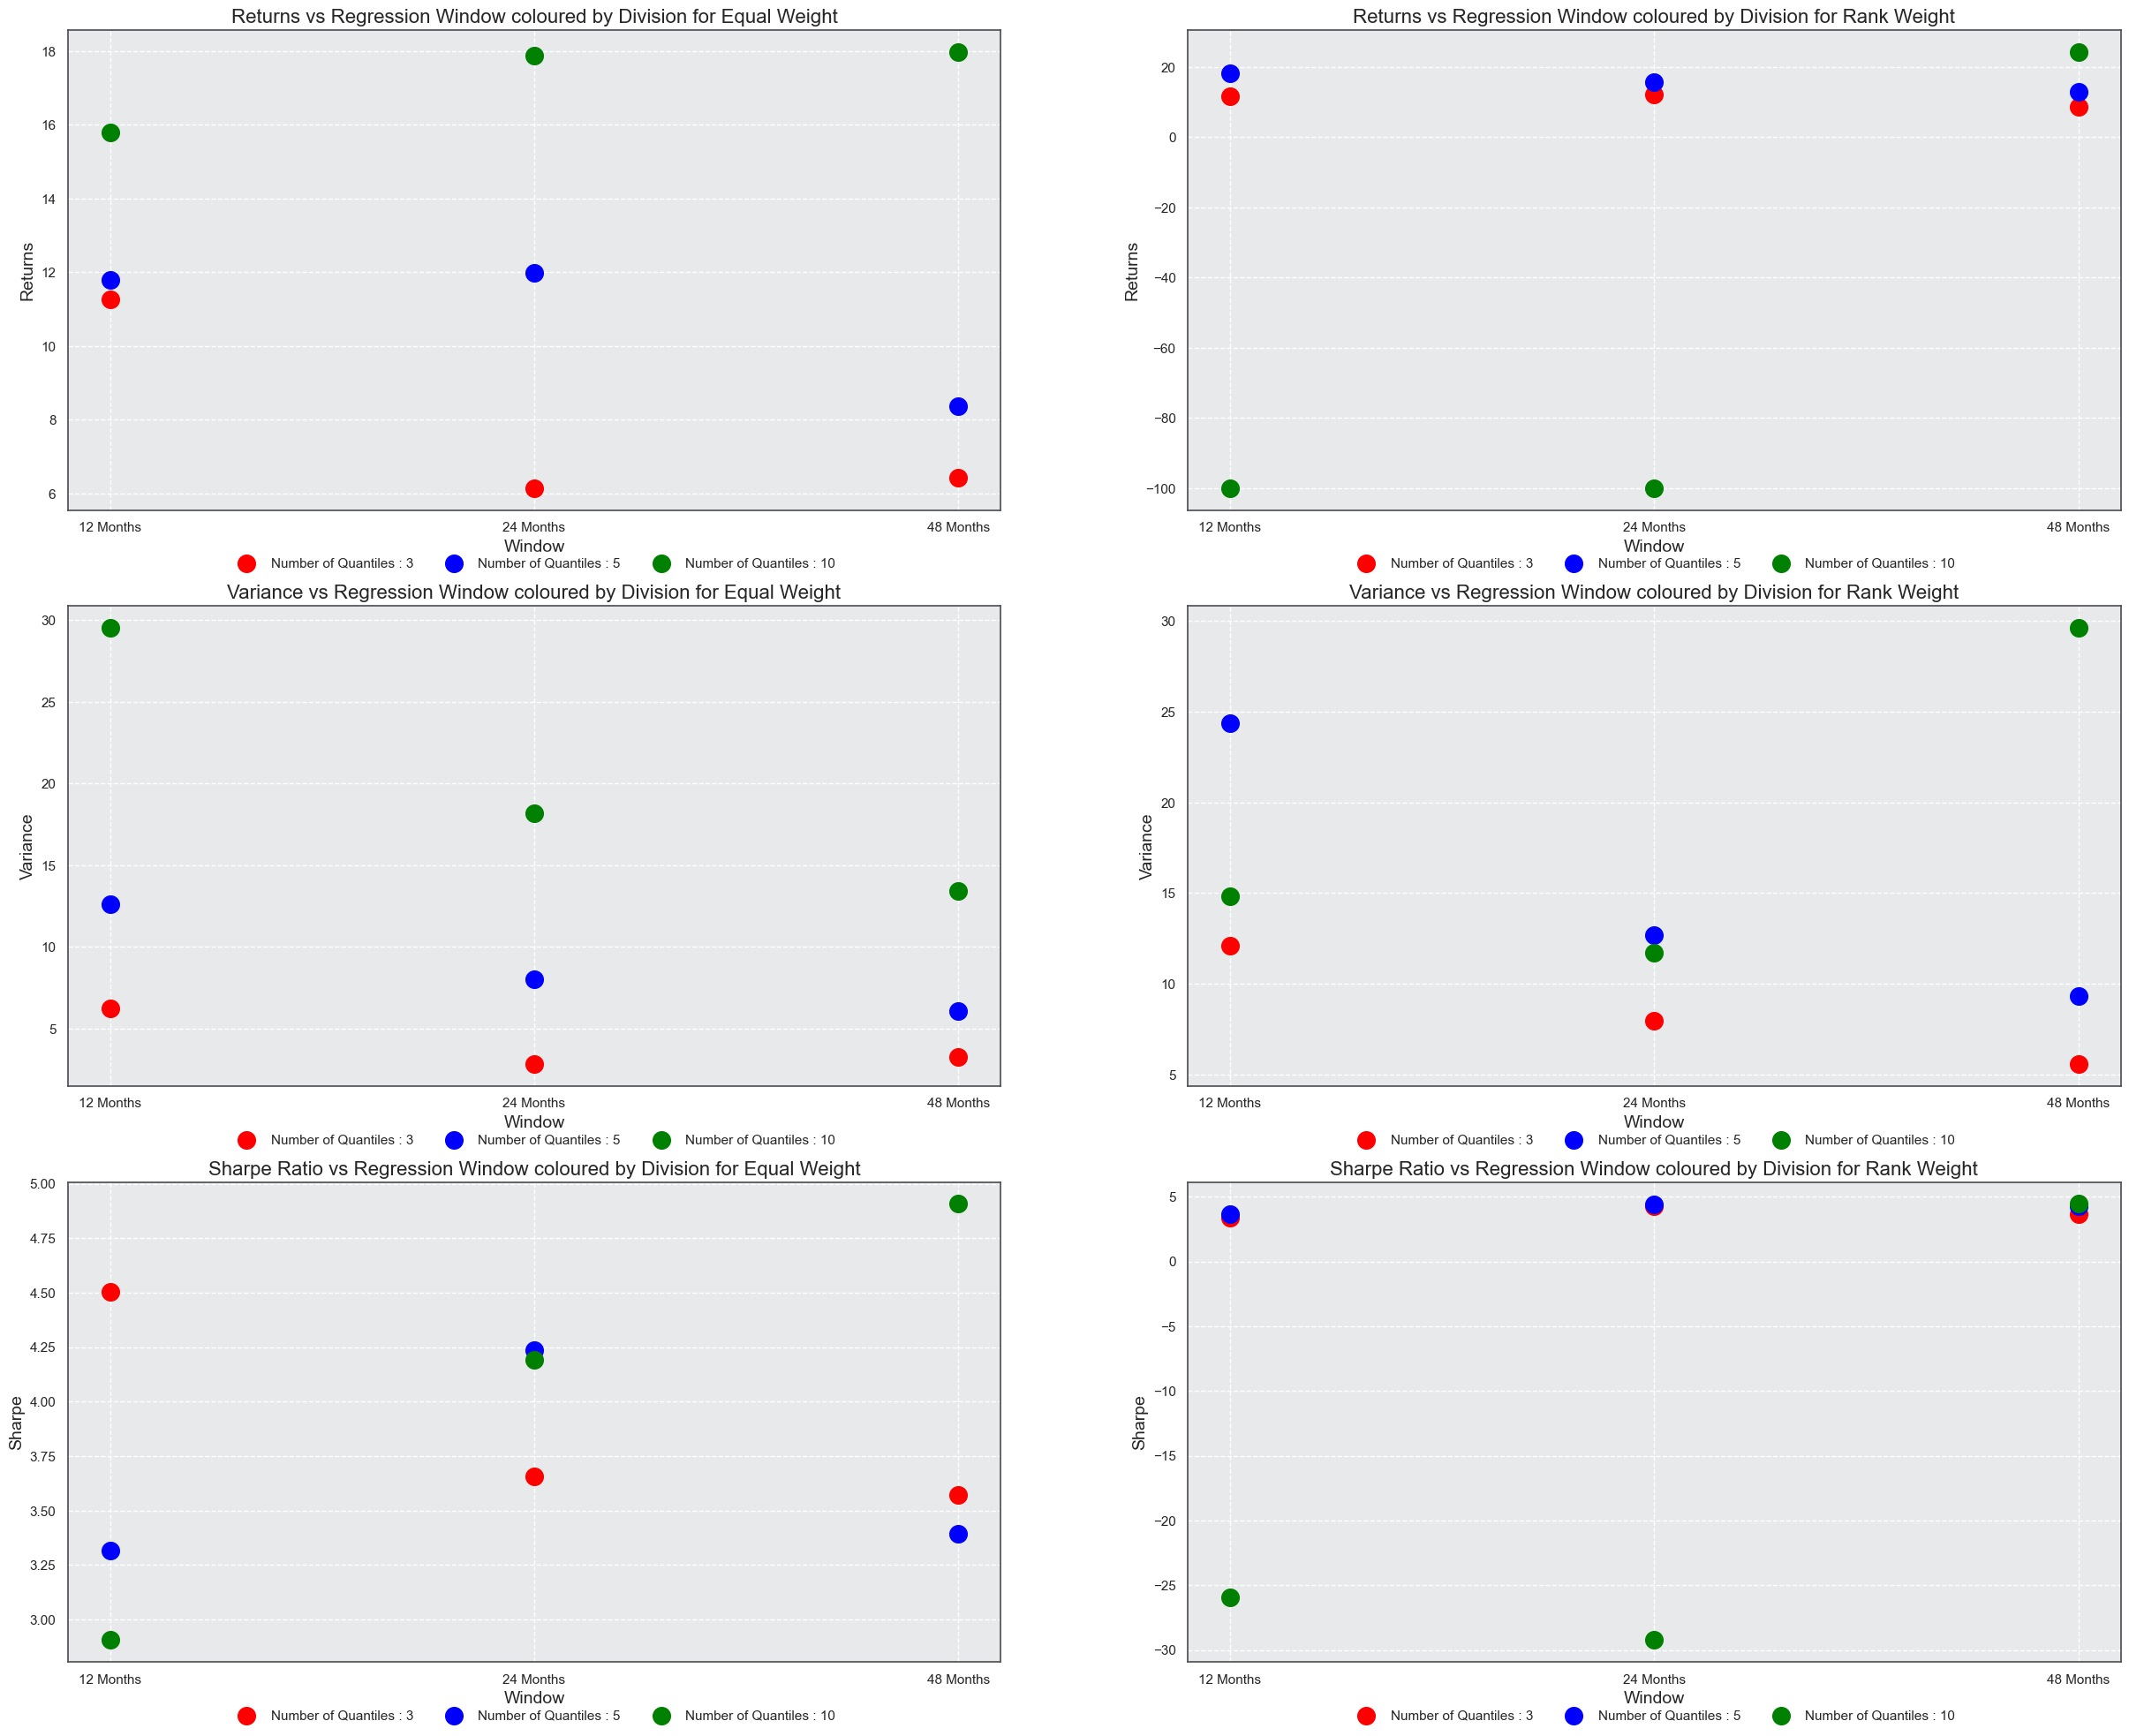

In [106]:
performance_plots()

In order to visualize the cumulative performance of the strategies I have plotted the lowest and hightest variance as well as the lowest and highest sharpe strategies below. On all plots I have added the performance of the market minus the risk free rate for comparison.

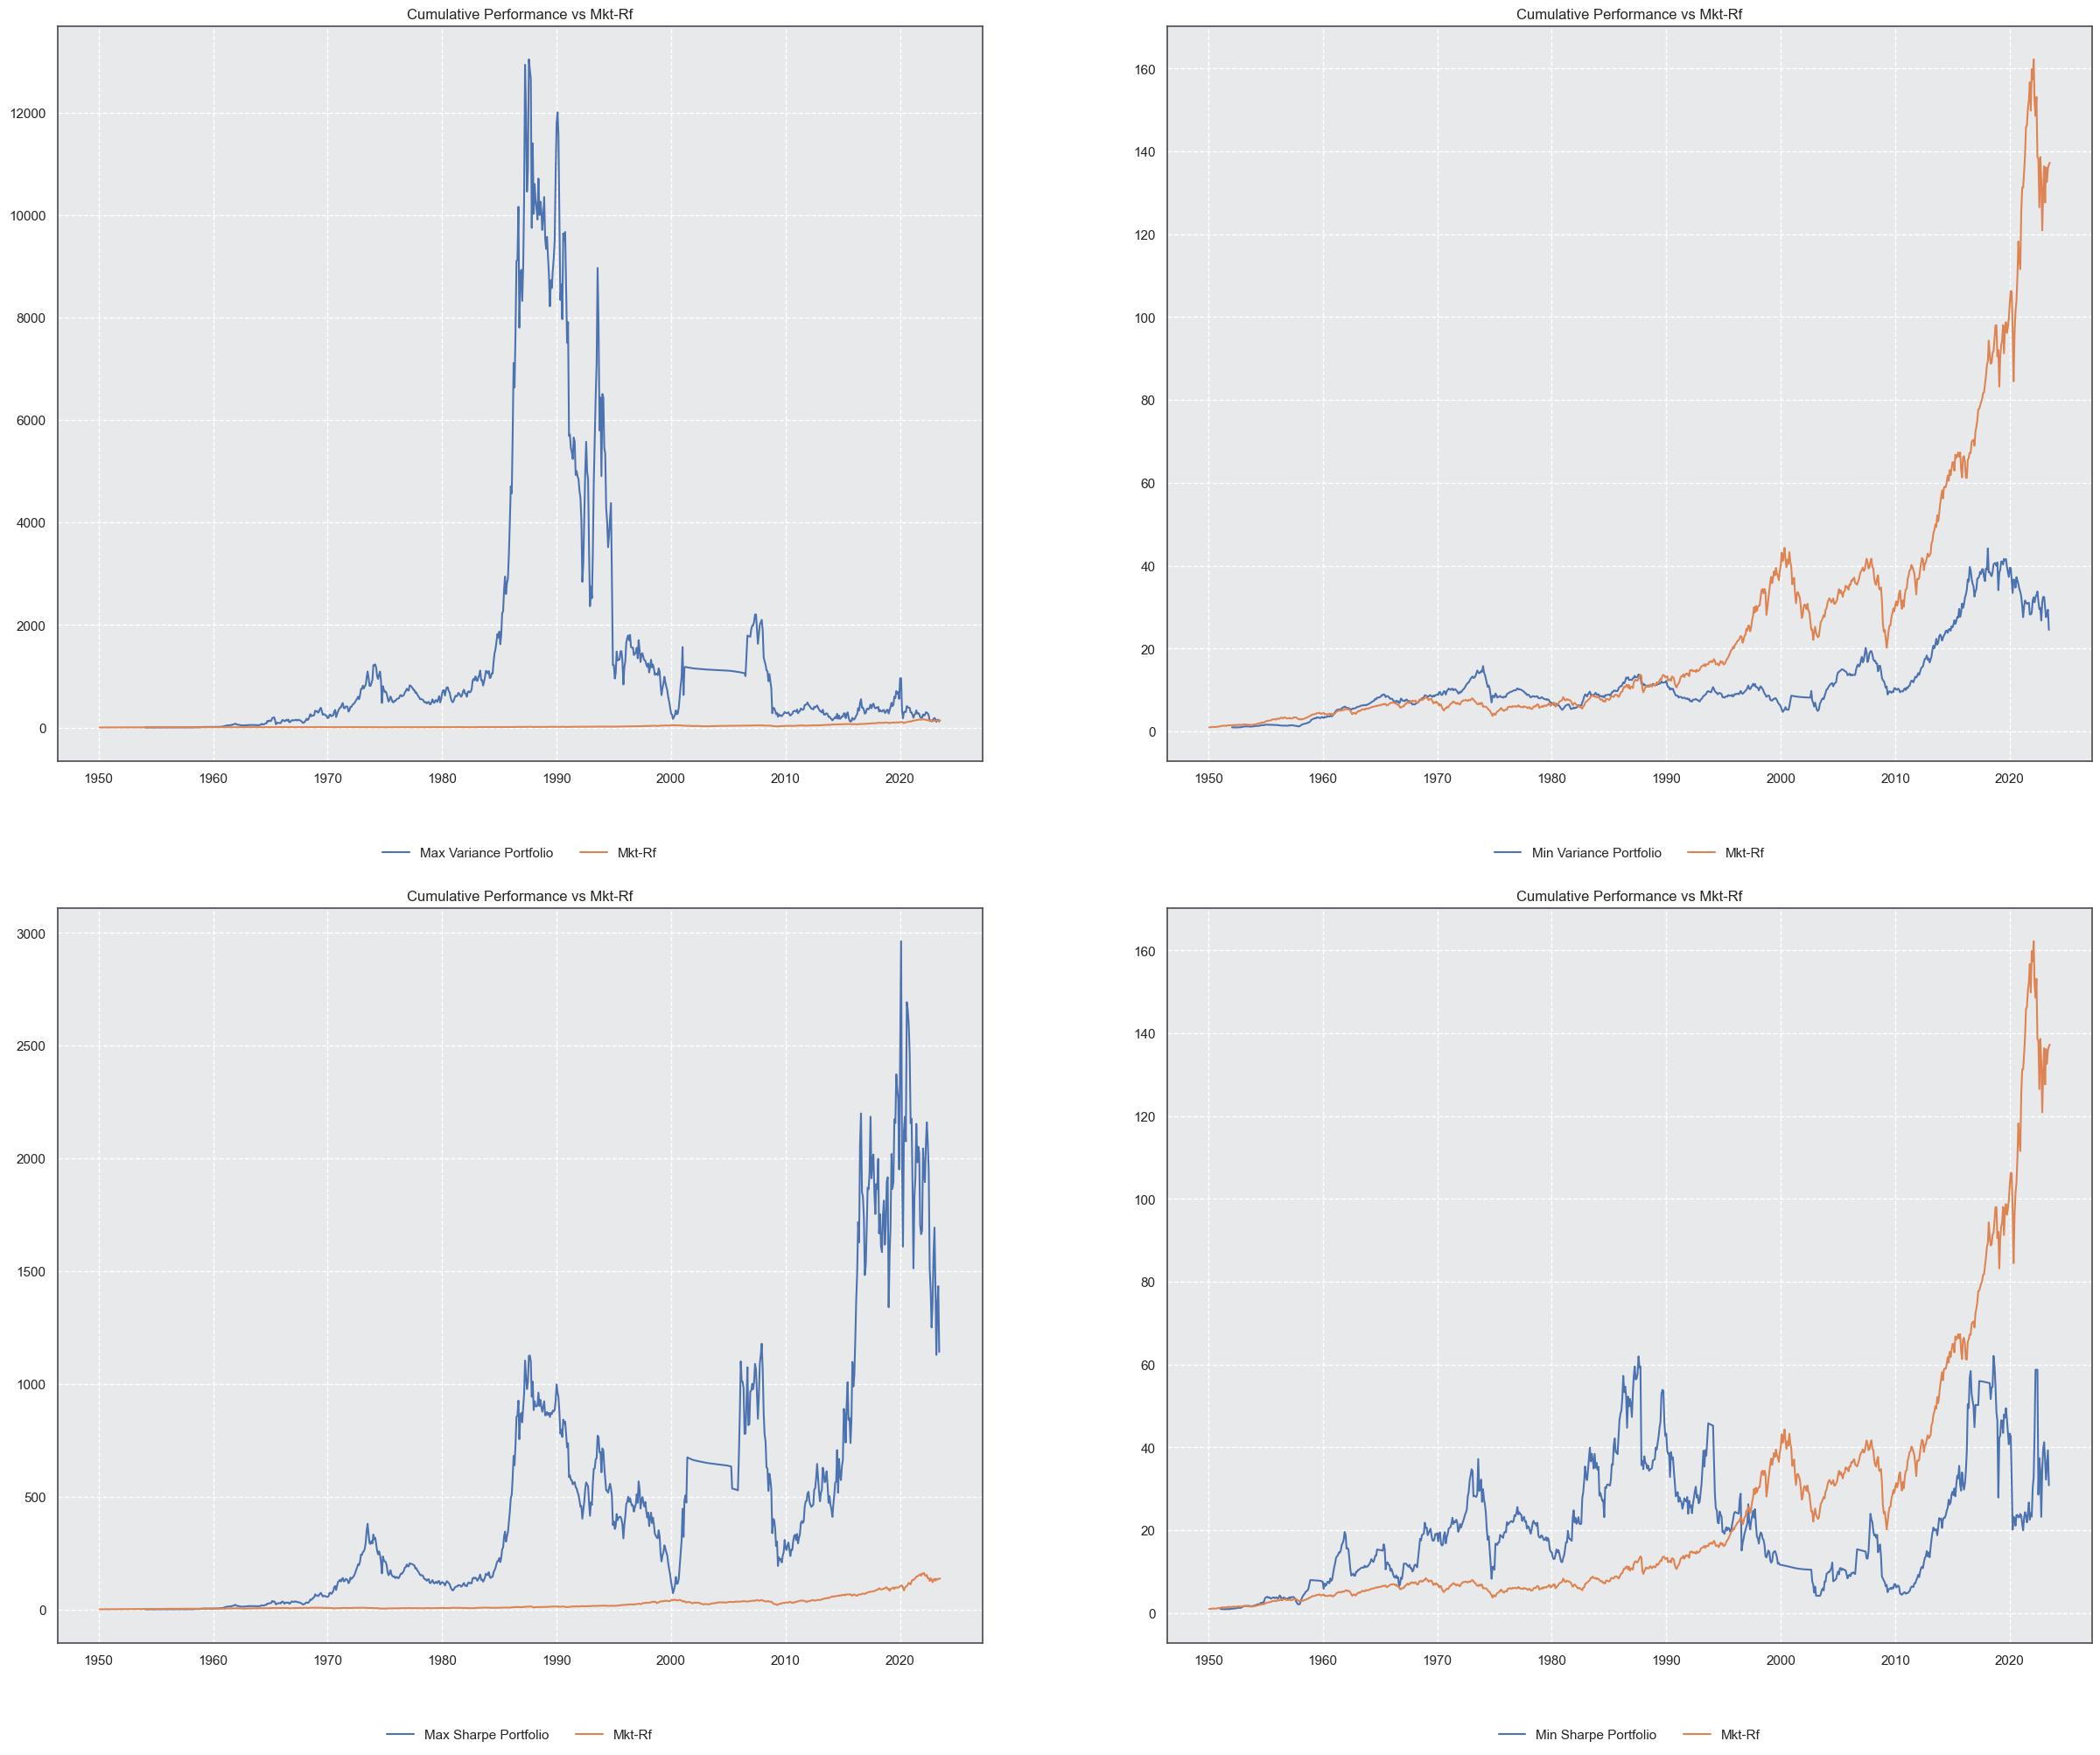

In [107]:
performance_vs_mkt_plots()

As you can see the highest sharpe strategy outperforms the market risk free returns quite substancially. However is also important to note that we have assumed a zero trading cost for all of our strategies but in practise there would be costs associated with rebalacing the portfolios each month. Therefore in reality we would not expected to see returns of this magnitude.